In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


In [5]:
raw.columns

Index(['id_str', 'created_at', 'follower_count', 'friends_count', 'statefips',
       'countyfips', 'countyname', 'is_urban', 'ogtext', 'cleantext',
       'mentions', 'hashtags', 'pos', 'ner', 'sentiment', 'sent_confidence',
       'date', 'week', 'time', 'hour', 'is_negative', 'is_positive',
       'state_name', 'state_abv', 'fips', 'count'],
      dtype='object')

# getting counties by rural/urban

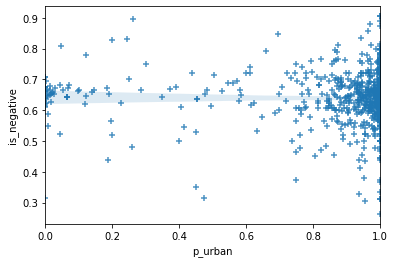

In [24]:
df = raw.groupby(['countyname']).agg({'count':'count', 'is_urban':'sum', 'is_negative':'mean'}).reset_index()
df['is_rural'] = df['count'] - df['is_urban']
df['p_urban'] = df['is_urban'] / df['count']

df = df[df['count'] > 15]

sns.regplot(y='is_negative', x='p_urban', data=df, marker='+')

In [26]:
df.corr()**2

,count,is_urban,is_negative,is_rural,p_urban
count,1.000000,9.139234e-01,0.000432,8.571610e-02,0.000784
is_urban,0.913923,1.000000e+00,0.000893,4.136697e-07,0.017636
is_negative,0.000432,8.929220e-04,1.000000,7.057080e-04,0.000419
is_rural,0.085716,4.136697e-07,0.000706,1.000000e+00,0.279049
p_urban,0.000784,1.763568e-02,0.000419,2.790486e-01,1.000000


In [29]:
import scipy
x= df['p_urban']
y= df['is_negative']

print(scipy.stats.pearsonr(x, y))

(-0.02045823348209561, 0.5805239169287719)


# t test between urban and rural counties

In [37]:
df2 = df[df['p_urban'] < 0.8]
df2 = df2[df2['p_urban'] > 0.2]
df2.describe()

,count,is_urban,is_negative,is_rural,p_urban
count,73.000000,73.000000,73.000000,73.000000,73.000000
mean,258.054795,131.657534,0.638138,126.397260,0.605688
std,806.732037,414.608424,0.103956,431.068399,0.172041
min,16.000000,5.000000,0.315789,4.000000,0.227804
25%,24.000000,14.000000,0.600000,10.000000,0.473684
50%,53.000000,28.000000,0.652174,17.000000,0.647059
75%,123.000000,83.000000,0.703125,36.000000,0.757576
max,5825.000000,3382.000000,0.894737,2644.000000,0.797688
